In [214]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.optim as optim
import tushare as ts 

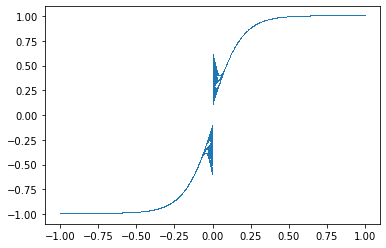

In [215]:
# define the parameters
N = 600;
s = 5;
a1 = 5;
a2 = 5;
b1 = 1;
b2 = 1;
eu = 0;
ev = 0;
k = 500;
c = 1;
e = 0.02;
x = 0;

# initialize

u = np.zeros([N])
v = np.zeros([N])
w = np.zeros([N])
z = np.zeros([N])
z[0] = 0.2  # IC of z set to 0.2
u[0] = 0.2
Lee = np.zeros([1000,100]);    
x_aix = np.zeros([1000*100]);
j = 0


for i in np.arange(-1,1,0.002):
#     valueOf_stimulus_i = sprintf('%0.5g',i)
    sim = i + e*np.sign(i)
    for t in range(0,N-1):     
        tempu = a1*u[t] - a2*v[t] + sim - eu
        tempv = b1*u[t] - b2*v[t] - ev
        u[t+1] = (np.exp(s*tempu) - np.exp((-1)*s*tempu))/(np.exp(s*tempu) + np.exp((-1)*s*tempu))
        v[t+1] = (np.exp(s*tempv) - np.exp((-1)*s*tempv))/(np.exp(s*tempv) + np.exp((-1)*s*tempv))
        w[t+1] = (np.exp(s*sim)   - np.exp((-1)*s*sim))  /(np.exp(s*sim) + np.exp((-1)*s*sim))
        z[t+1] = (u[t+1] - v[t+1]) * np.exp (-1*k*sim*sim) + c*w[t+1]        
        if t >=499:
#  	        plot(x/1000, z(t+1)/2 + 0.5);
            x_aix[j] = i
            j += 1
#            Lee[x,t-499] = z[t+1]/2 +0.5;  # 0~1
            Lee[x,t-499] = z[t+1];  # -1~1
    x = x+1

plt.figure(1)
fig = np.reshape(Lee, [1000*100])
plt.plot(x_aix,fig,',')
plt.savefig('1')
plt.show()

data = pd.DataFrame(Lee)

In [216]:
values = data

In [217]:
def LeeOsc(x):
        output = np.zeros([x.shape[0],x.shape[1]])  # 取矩阵的行列数
        n = output.shape[0]
        m = output.shape[1]
        for i in range(0, n):
            for j in range(0, m):
                if x[i][j] + 1 <= 0:
#                   output[i][j] = 0.0000372  # 0~1
                    output[i][j] = -0.9999  # -1~1
                elif x[i][j] - 1 >= 0:
#                   output[i][j] = 0.999972831  # 0~1
                    output[i][j] = 0.9999
                else:
                    row = math.floor((x[i][j] + 1) / 0.002)  #定义x轴
                    col = random.randint(0, 99)              #定义y轴
                    output[i][j] = values.iat[row, col]
        return output

In [218]:
"""
ts.set_token('cece2a8ee94291a9ea0aa278e8c23a92df485b1b4b059a85823c989c')
ts_pro = ts.pro_api()
# 股票代码
ts_code = '399001.SZ'
# 开始时间
start_date = '20100101'
# 结束时间
end_date = '20200101'
df = ts_pro.index_daily(
        ts_code=ts_code,
        start_date=start_date,
        end_date=end_date)
# 将获取的文件存储在本地
df.to_csv('399001.SZ.csv', index=0)
df.head()
"""

"\nts.set_token('cece2a8ee94291a9ea0aa278e8c23a92df485b1b4b059a85823c989c')\nts_pro = ts.pro_api()\n# 股票代码\nts_code = '399001.SZ'\n# 开始时间\nstart_date = '20100101'\n# 结束时间\nend_date = '20200101'\ndf = ts_pro.index_daily(\n        ts_code=ts_code,\n        start_date=start_date,\n        end_date=end_date)\n# 将获取的文件存储在本地\ndf.to_csv('399001.SZ.csv', index=0)\ndf.head()\n"

In [219]:
"""
df = pd.read_csv('399001.SZ.csv')
# 按照时间进行排序，方便预测处理
df = df.sort_values(['trade_date'], ascending=True)
# 简要查看文件信息
df.to_csv('399001.SZ.csv', index=0)
df.head()
"""

"\ndf = pd.read_csv('399001.SZ.csv')\n# 按照时间进行排序，方便预测处理\ndf = df.sort_values(['trade_date'], ascending=True)\n# 简要查看文件信息\ndf.to_csv('399001.SZ.csv', index=0)\ndf.head()\n"

In [ ]:
s_data = pd.read_csv('./Data/000001.SH.csv', parse_dates=True)
s_data_copy = s_data
t = 3000
plt.plot(s_data["close"][:t],'r',lw = 1)
plt.legend(["close"])
plt.grid(True)
plt.axis("tight")
plt.xlabel("Timeseries")
plt.ylabel("Close")
plt.title("Daily-Close")
plt.show()

In [221]:
#定义训练集
data_csv = pd.read_csv('./Data/000001.SH.csv')
use_cols = ['close']
data_csv = data_csv [use_cols]
data_csv = data_csv.dropna()
# 为了归一化后复现原来数据
close_min = data_csv['close'].min()
close_max = data_csv['close'].max()
# 归一化处理（0，1）
data_csv=data_csv.apply(lambda x:(x-min(x))/(max(x)-min(x)))
data_csv.head()

close
0  0.402242
1  0.414187
2  0.405493
3  0.386391
4  0.387392

In [222]:
import numpy as np 
# 序列长度为5，即用前5的数据预测之后一天的数据
sequence = 30
X = []
Y = []
for i in range(data_csv.shape[0]-sequence):
    # 选择use_cols作为特征
    X.append(np.array(data_csv.iloc[i:(i+sequence)].values, dtype=np.float))
    # 选择close作为标签输出
    Y.append(np.array(data_csv.iloc[(i+sequence)],dtype=np.float))

In [223]:
trainx, trainy = X[:int(0.7*data_csv.shape[0])], Y[:int(0.7*data_csv.shape[0])]
testx, testy = X[int(0.7*data_csv.shape[0]):], Y[int(0.7*data_csv.shape[0]):]

print(len(trainx))
print(len(testx))

1701
700


In [224]:
torch.manual_seed(1)

In [225]:
# list -> numpy
trainx = np.array(trainx)
trainy = np.array(trainy)
testx = np.array(testx)
testy = np.array(testy)

trainx = trainx.astype('float32')
trainy = trainy.astype('float32')
testx = testx.astype('float32')
testy = testy.astype('float32')


print(trainx.shape)
print(trainy.shape)
print(testx.shape)
print(testy.shape)
# model size (seq_size, batch_size, feature_size)
trainx = trainx.reshape(-1,1, sequence)  # (seq_size, batch_size, feature_size)
trainy = trainy.reshape(-1,1, 1)
testx = testx.reshape(-1, 1,sequence)
# numpy -> torch
trainx = Variable(torch.from_numpy(trainx))
trainy = Variable(torch.from_numpy(trainy))
testx = Variable(torch.from_numpy(testx))


print('trainx size: ', trainx.size())
print('trainy size: ', trainy.size())
print('testx size: ', testx.size())

(1701, 30, 1)
(1701, 1)
(700, 30, 1)
(700, 1)
trainx size:  torch.Size([1701, 1, 30])
trainy size:  torch.Size([1701, 1, 1])
testx size:  torch.Size([700, 1, 30])


In [226]:
class CRNN(nn.Module):
    def __init__(self,in_feature, hidden_size, n_class):
        super(CRNN, self).__init__()
        self.in_feature = in_feature
        self.hidden_size = hidden_size
        self.n_class = n_class
        self.in2hidden = nn.Linear(self.in_feature + self.hidden_size,self.hidden_size)
        self.hidden2out = nn.Linear(self.hidden_size,self.n_class)
    

    ##此处input的尺寸为[seq_len,batch,in_feature]
    def forward(self,input,pre_state):
        T = input.shape[0]
        batch = input.shape[1]
        a = Variable(torch.zeros(T,batch,self.hidden_size))             #a-> [T,hidden_size]
        o = Variable(torch.zeros(T,batch,self.n_class))                 #o ->[T,n_class]
        predict_y = Variable(torch.zeros(T,batch,self.n_class))
        # pre_state = Variable(torch.zeros(batch, self.hidden_size))  # pre_state=[batch,hidden_size]


        if pre_state is None:
            pre_state = Variable(torch.zeros(batch, self.hidden_size))  # hidden ->[batch,hidden_size]

        for t in range(T):
            # input:[T,batch,in_feature]
            tmp = torch.cat((input[t], pre_state), 1)  #  [batch,in_feature]+[batch,hidden_size]-> [batch,hidden_size+in_featue]
            a[t] = self.in2hidden(tmp)                      #  [batch,hidden_size+in_feature]*[hidden_size+in_feature,hidden_size] ->[batch,hidden_size]
            hidden = a[t]*torch.Tensor(LeeOsc(a[t])).float()

            #这里不赋值的话就没有代表隐层向前传递
            pre_state = hidden

            o[t] = self.hidden2out(hidden)  # [batch,hidden_size]*[hidden_size,n_class]->[batch,n_class]
            #由于此次是一个单分类问题，因此不用softmax函数
            if self.n_class ==1:
                predict_y[t] = torch.sigmoid(o[t])
            else:
                predict_y[t] = F.Log_softmax(o[t])


        return predict_y, hidden

In [227]:
input_size = 30       #一个序列的长度,也就是输入特征数
n_hidden = 30      #隐层神经元数目
target_size = 1     #输出的尺寸

In [228]:
model = CRNN(in_feature=input_size,hidden_size=n_hidden,n_class=target_size)
print(model)

CRNN(
  (in2hidden): Linear(in_features=60, out_features=30, bias=True)
  (hidden2out): Linear(in_features=30, out_features=1, bias=True)
)


In [229]:
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_fun=nn.MSELoss()

In [230]:
num_epoch=100
# print(len(train_x))
#
for epoch in range(num_epoch):
    state=None
    out, state = model(trainx, state)
    loss=loss_fun(out,trainy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:  # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(epoch + 1, loss.item()))
    # state = None
    # #

Epoch: 10, Loss: 0.08741
Epoch: 20, Loss: 0.07554
Epoch: 30, Loss: 0.06097
Epoch: 40, Loss: 0.03428
Epoch: 50, Loss: 0.01201
Epoch: 60, Loss: 0.00542
Epoch: 70, Loss: 0.00297
Epoch: 80, Loss: 0.00265
Epoch: 90, Loss: 0.00249
Epoch: 100, Loss: 0.00235


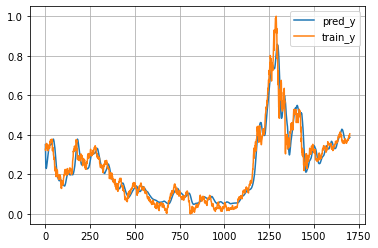

In [231]:
model = model.eval() 
hidden1=None
out2,_=model(trainx,hidden1)
plt.plot(out2.data.numpy().reshape(1701,1), label='pred_y')
plt.plot(trainy.reshape(1701,1), label='train_y')
plt.grid(True)
plt.axis("tight")
plt.legend()
plt.show()

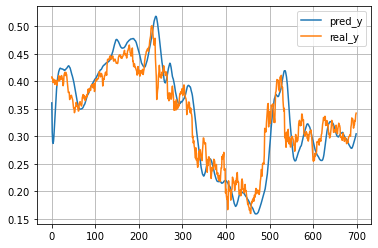

In [232]:
# 测试集输入模型进行预测
model = model.eval() 
hidden2 = None
out3,_ = model(testx,hidden2)
plt.plot(out3.data.numpy().reshape(700,1),label='pred_y')
plt.plot(testy.reshape(700,1),label='real_y')
plt.legend()
plt.grid(True)
plt.axis("tight")
plt.savefig("CRNN-LeeOsc-Prediction(SZSE).png")
plt.show()

In [233]:
pred = out3.data.numpy().reshape(700,1)
real = testy.reshape(700,1)
print(pred.shape)
print(real.shape)

(700, 1)
(700, 1)


In [234]:
mse = mean_squared_error(pred, real)
rmse = math.sqrt(mean_squared_error(pred, real))
mae = mean_absolute_error(pred, real)
print('mean_squared_error: %.6f' % mse)
print('root_mean_squared_error: %.6f' % rmse)
print('mean_absolute_error: %.6f' % mae)

mean_squared_error: 0.001375
root_mean_squared_error: 0.037082
mean_absolute_error: 0.027641
